In [2]:
import torch 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

from scipy.stats import foldnorm
import matplotlib
from inline_labels import add_inline_labels

/opt/anaconda3/envs/plotting/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
x = np.linspace(2e-5, 5e0, 5)

noise_level_2 = np.abs(x)
quantiles_lower_01 = [foldnorm.ppf(0.15, 0.,0.,i) for i in noise_level_2]
quantiles_upper_01 = [foldnorm.ppf(0.85, 0.,0.,i) for i in noise_level_2]
quantiles_lower_05 = [foldnorm.ppf(0.05, 0.,0.,i) for i in noise_level_2]
quantiles_upper_05 = [foldnorm.ppf(0.95, 0.,0.,i) for i in noise_level_2]
quantiles_lower_005 = [foldnorm.ppf(0.005, 0.,0.,i) for i in noise_level_2]
quantiles_upper_005 = [foldnorm.ppf(0.995, 0.,0.,i) for i in noise_level_2]

In [4]:


Ytrue = torch.load("../../Atomistic_experiments/materials_model_predictions/H2O_size_extensive/size_energy.pt").detach().numpy().flatten()[:1000]
Ypred = torch.load("../../Atomistic_experiments/materials_model_predictions/H2O_size_extensive/size_pred_energy.pt").detach().numpy().flatten()[:1000]
Ypred_std = np.sqrt(torch.load("../../Atomistic_experiments/materials_model_predictions/H2O_size_extensive/size_pred_energy_var.pt").detach().numpy().flatten())[:1000]

Ytrue_512 = torch.load("../../Atomistic_experiments/materials_model_predictions/H2O_size_extensive/size_energy.pt").detach().numpy().flatten()[1000:]
Ypre_512 = torch.load("../../Atomistic_experiments/materials_model_predictions/H2O_size_extensive/size_pred_energy.pt").detach().numpy().flatten()[1000:]
Ypred_std_512 = np.sqrt(torch.load("../../Atomistic_experiments/materials_model_predictions/H2O_size_extensive/size_pred_energy_var.pt").detach().numpy().flatten())[1000:]

Y_M = torch.load("../../Atomistic_experiments/materials_model_predictions/H2O_size_extensive/size_M_pred_energy.pt").detach().numpy()

sizes = np.array([32,64,128,256,512])

# composition energy is only written to the mean committee energies
E_composition = Ypred - Y_M[:1000].mean(axis=1)
E_composition = E_composition.reshape(-1,1)

Y_M_w_composition = Y_M[:1000] + E_composition

# composition energy is only written to the mean committee energies
E_composition_512 = Ypre_512 - Y_M[1000:].mean(axis=1)
E_composition_512 = E_composition_512.reshape(-1,1)
Y_M_w_composition_512 = Y_M[1000:] + E_composition_512

#split into blocks corresponding to potential energies of 32,64,128,256
blocks, blocks_true = np.split(Y_M_w_composition[:1000],4,axis=0),np.split(Ytrue,4,axis=0)

# append the 512 block
blocks.append(Y_M_w_composition_512)
blocks_true.append(Ytrue_512)


err_tot_pred = []
err_tot_empirical = []

bias_tot_pred = []
bias_tot_empirical = []

err_thermal_pred = []
err_thermal_empirical = []

predicted_bias_2 = []

z_s_wo_bias = []
sigmas_wo_bias = []

for block, block_true in zip(blocks, blocks_true):
    #blockwise error

    V_ref = block_true
    

    # check other ways of predicting total bias
    V_bar = np.mean(block,axis=1)
    V_bar_mean = np.mean(V_bar)
    
    V_k_mean = np.mean(block, axis=0)

    bias_tot_pred.append(np.std(V_k_mean-V_bar_mean))

    err_tot_empirical.append(np.mean(np.abs(V_bar-V_ref)))
    err_tot_pred.append(np.mean(np.std(block,axis=1)))    

    #blockwise bias
    bias_tot_empirical.append(np.abs(np.mean(V_bar - V_ref)))

    #mean estimator wise over N
    bias_estimator_wise = np.mean(block,axis=0)

    #std over mean estimator wise N
    #bias_tot_pred.append(np.std(bias_estimator_wise))
    
    #remove predicted bias
    block_wo_bias = block - bias_estimator_wise
    
    #predicted thermal error is std of committe after removal of predicted bias
    err_thermal_pred.append(np.mean(np.std(block_wo_bias,axis=1)))

    # now remove the true bias
    block_wo_bias_mean = block - (np.mean(V_bar - V_ref))
    V_bar_wo_bias = np.mean(block_wo_bias_mean,axis=1)

    #get errors wo bias
    z_wo_bias = np.mean(np.abs(V_bar_wo_bias - V_ref))
    err_thermal_empirical.append(z_wo_bias)


    


    

NameError: name 'V_bar' is not defined

In [27]:
import matplotlib
from inline_labels import add_inline_labels

/var/folders/7y/yhl65v0j5m3g8zj_xwkzq44w0000gn/T/ipykernel_35227/370104892.py:70: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  axs[0].scatter(np.concatenate([mean_uq.flatten(),np.mean(Ypred_std_512).flatten()])[i],
Label placement: 100%|#########################| 52/52 [00:00<00:00, 109.54it/s]
/var/folders/7y/yhl65v0j5m3g8zj_xwkzq44w0000gn/T/ipykernel_35227/370104892.py:130: MatplotlibDeprecationWarning: An artist whose label starts with an underscore was passed to legend(); such artists will no longer be ignored in the future.  To suppress this warning, explicitly filter out such artists, e.g. with `[art for art in artists if not art.get_label().startswith('_')]`.
  axs[1].legend(loc="lower right",


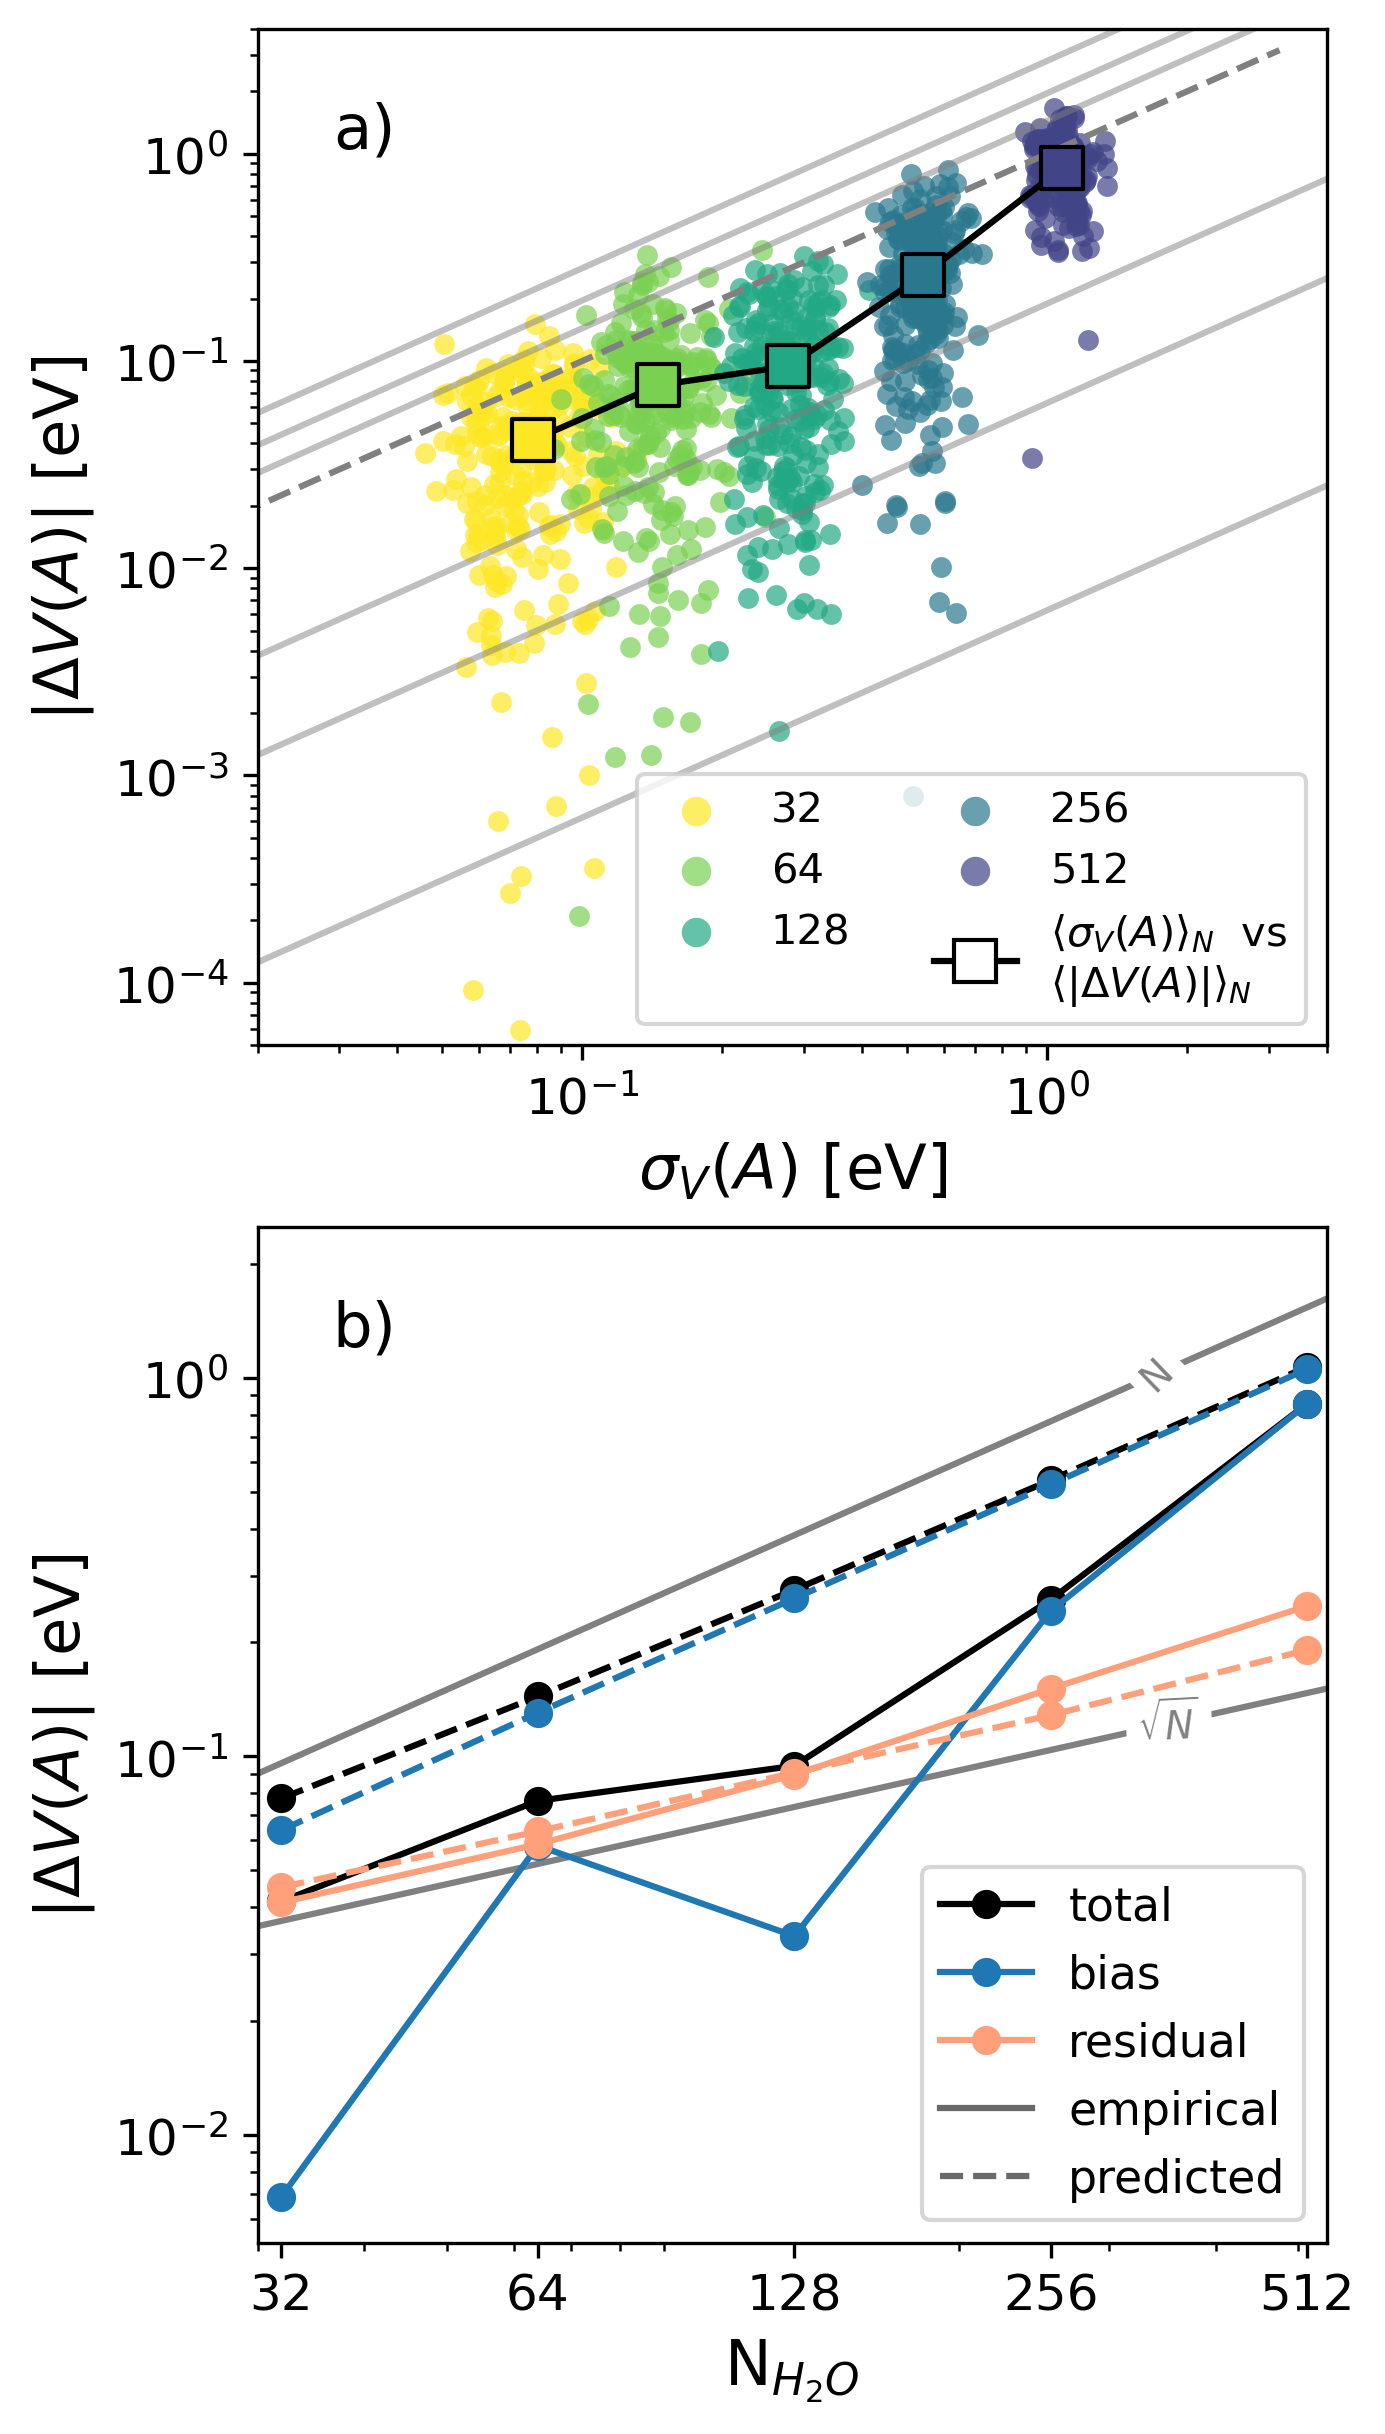

<Figure size 640x460 with 0 Axes>

In [30]:
fig, axs = plt.subplots(2, 1, figsize=(4.5, 8),dpi=300,constrained_layout=True,)
# H2O
x = np.linspace(2e-5, 5e0, 5)

cmap = plt.get_cmap('viridis')
plt.rc('axes', labelsize=13.5)
plt.rcParams.update({'font.size': 11.0})
matplotlib.rc('xtick', labelsize=12.0) 
matplotlib.rc('ytick', labelsize=12.0) 
plt.rc('axes', labelsize=15.)

colors = cmap(np.linspace(1., 0.2, 5))

#Ytrue[0:250], Ytrue[250:500] = Ytrue[250:500].copy(), Ytrue[0:250].copy()
#Ypred[0:250], Ypred[250:500] = Ypred[250:500].copy(), Ypred[0:250].copy()
#Ypred_std[0:250], Ypred_std[250:500] = Ypred_std[250:500].copy(), Ypred_std[0:250].copy()
ALPHA_SCATTER = 0.7

z_512 = np.abs(Ytrue_512-Ypre_512)
z_mean_512 = np.mean(z_512)



z = np.abs(Ytrue-Ypred).reshape(4,250)
err_pred = Ypred_std.reshape(4,250)

z_mean = np.mean(z,axis=1).T
z_std = np.std(z,axis=1).T

mean_uq = np.mean(Ypred_std.reshape(4,250),axis=1)
std_uq = np.std(Ypred_std.reshape(4,250),axis=1)


sizes_dft = np.array([32,64,128,256])
plt.figure(figsize=(6.4,4.6))

MARKERSIZE = 25.

id = -4
axs[0].scatter(err_pred[id],z[id],color=colors[0], s=MARKERSIZE, rasterized=True, alpha=ALPHA_SCATTER, linewidth=0)
axs[0].scatter([],[],label="{}".format(sizes_dft[id]), alpha=ALPHA_SCATTER,color=colors[0],linewidth=0,s=50.)

id = -3
axs[0].scatter(err_pred[id],z[id],color=colors[1], s=MARKERSIZE, rasterized=True, alpha=ALPHA_SCATTER, linewidth=0)
axs[0].scatter([],[],label="{}".format(sizes_dft[id]), alpha=ALPHA_SCATTER,color=colors[1],linewidth=0,s=50.)

id = -2
axs[0].scatter(err_pred[id],z[id],color=colors[2],s=MARKERSIZE,  rasterized=True, alpha=ALPHA_SCATTER, linewidth=0)
axs[0].scatter([],[],label="{}".format(sizes_dft[id]), alpha=ALPHA_SCATTER,color=colors[2],linewidth=0,s=50.)

id = -1
axs[0].scatter(err_pred[id],z[id],color=colors[3], s=MARKERSIZE, rasterized=True, alpha=ALPHA_SCATTER, linewidth=0)
axs[0].scatter([],[],label="{}".format(sizes_dft[id]), alpha=ALPHA_SCATTER,color=colors[3],linewidth=0,s=50.)

axs[0].scatter(Ypred_std_512,z_512 ,color=colors[4], s=MARKERSIZE, rasterized=True, alpha=ALPHA_SCATTER, linewidth=0)
axs[0].scatter([],[],label="{}".format("512"), alpha=ALPHA_SCATTER,color=colors[4],linewidth=0,s=50.)

axs[0].plot(x, quantiles_upper_05, color='gray', alpha=0.5)
axs[0].plot(x, quantiles_lower_05, color='gray', alpha=0.5)
axs[0].plot(x, quantiles_upper_01, color='gray', alpha=0.5)
axs[0].plot(x, quantiles_lower_01, color='gray', alpha=0.5)
axs[0].plot(x, quantiles_upper_005, color='gray', alpha=0.5)
axs[0].plot(x, quantiles_lower_005, color='gray', alpha=0.5)

axs[0].plot(np.logspace(-2,0.5),np.logspace(-2,0.5),linestyle="--", color="grey")


#make big
for i in range(5):
    axs[0].scatter(np.concatenate([mean_uq.flatten(),np.mean(Ypred_std_512).flatten()])[i],
                   np.concatenate([z_mean.flatten(),z_mean_512.flatten()])[i],marker='s',
                     s=100, edgecolors='black',c=colors[i], zorder=2)
    


axs[0].plot([],[] , 
            's', linestyle="-",  markersize=10, markeredgecolor='black',markerfacecolor="white", color="black", label=r"$\langle\sigma_{V}(A)\rangle_{N}$  vs " + "\n" + r"$\langle|\Delta V(A)|\rangle_{N}$")

axs[0].plot(np.concatenate([mean_uq.flatten(),np.mean(Ypred_std_512).flatten()]),
            np.concatenate([z_mean.flatten(),z_mean_512.flatten()]) ,
            linestyle="-",color="black",zorder=1)


#plt.plot(sizes[:7],z_std, marker="o")
#plt.plot(np.logspace(-2,0),np.sqrt(np.logspace(-2,0))*0.1)
axs[0].set_xscale("log")
axs[0].set_yscale("log")
axs[0].set_xlim(2e-02,4e0)
axs[0].set_ylim(5e-05,4e0)
legend = axs[0].legend(fontsize=10., ncols=2) #markerscale=2.)
#axs[0].set_title(r"Shallow ensemble NLL, no calibration")
axs[0].set_xlabel(r"$\sigma_{V}(A)$ [eV]")
axs[0].set_ylabel(r"$|\Delta V(A)|$ [eV]")


# Adjusting the marker size in the legend
desired_size = 25  # Specify the desired size here
#for handle in legend.legendHandles:
#    handle.set_markersize(desired_size) 
#legend.legendHandles[0]._legmarker.set_markersize(15)

axs[1].plot(np.logspace(1.2,2.8,), 0.003*np.logspace(1.2,2.8),linestyle="-",color="gray", label=r"N")
axs[1].plot(np.logspace(1.2,2.8,), 0.0065*np.sqrt(np.logspace(1.2,2.8)),linestyle="-", color="gray", label=r"$\sqrt{N}$")
add_inline_labels(axs[1], with_overall_progress=True, fontsize="small")

handle_tot, = axs[1].plot(sizes,err_tot_pred, marker="o", linestyle="--", color="black")#, label=r"total$_{(pred)}$")
handle_tot_2, = axs[1].plot(sizes,err_tot_empirical, marker="o", linestyle="-",color="black",label="total")# label=r"total$_{(empir)}$")

handle4, = axs[1].plot(sizes, bias_tot_pred, linestyle="--", color="tab:blue",marker="o")#,label=r"bias$_{(pred)}$")
#handle10, = axs[1].plot(sizes, predicted_bias_2, color="red")
handle5, = axs[1].plot(sizes, bias_tot_empirical, marker="o", color="tab:blue",label="bias") #, label=r"bias$_{(empir)}$" )
#axs[1].plot(sizes, bias_tot_pred, marker="o", color="tab:orange", linestyle="--",label=r"std$[\overline{V}_{n} - \overline{V}_{true}]$")

handle6, = axs[1].plot(sizes, err_thermal_empirical, marker="o", linestyle="-", color="lightsalmon", label="residual")# label=r"resid$_{(empir)}$")
handle7, = axs[1].plot(sizes, err_thermal_pred, marker="o", linestyle="--", color="lightsalmon")#, label=r"resid$_{(pred)}$")


handle8, = axs[1].plot([],[], linestyle="-", color="dimgray", label="empirical" )
handle9, = axs[1].plot([],[], linestyle="--", color="dimgray", label="predicted" )

#plt.plot(sizes, np.array(bias_tot_pred)+np.array(err_thermal_pred), marker="o", color="tab:red", linestyle="--", label=r"")



#axs[1].plot(np.logspace(1.5,2.8,), 0.008*np.sqrt(np.logspace(1.5,2.8)),linestyle="--", color="gray")#, label=r"$\sqrt{N}$")

axs[1].loglog()
axs[1].set_xlabel(r"N$_{H_{2}O}$")
axs[1].set_ylabel("$|\Delta V(A)|$ [eV]")
axs[1].legend(loc="lower right", 
              handles=[handle_tot,handle_tot_2,
                       handle4,handle5,handle6,handle7,handle8,handle9])#bbox_to_anchor=(1.1,1))

axs[0].text(0.1, 0.9, 'a)', horizontalalignment='center', verticalalignment='center', transform=axs[0].transAxes, fontsize=15)
axs[1].text(0.1, 0.9, 'b)', horizontalalignment='center', verticalalignment='center', transform=axs[1].transAxes, fontsize=15)

#set explicit x ticks
axs[1].set_xticks(sizes)
axs[1].set_xticklabels(sizes)
axs[1].set_xlim(30,540)

plt.show()

fig.savefig("size_extensive_error_analysis.pdf",bbox_inches='tight',dpi=300)




/var/folders/7y/yhl65v0j5m3g8zj_xwkzq44w0000gn/T/ipykernel_53869/3820277123.py:70: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  axs[0].scatter(np.concatenate([mean_uq.flatten(),np.mean(Ypred_std_512).flatten()])[i],


NameError: name 'add_inline_labels' is not defined

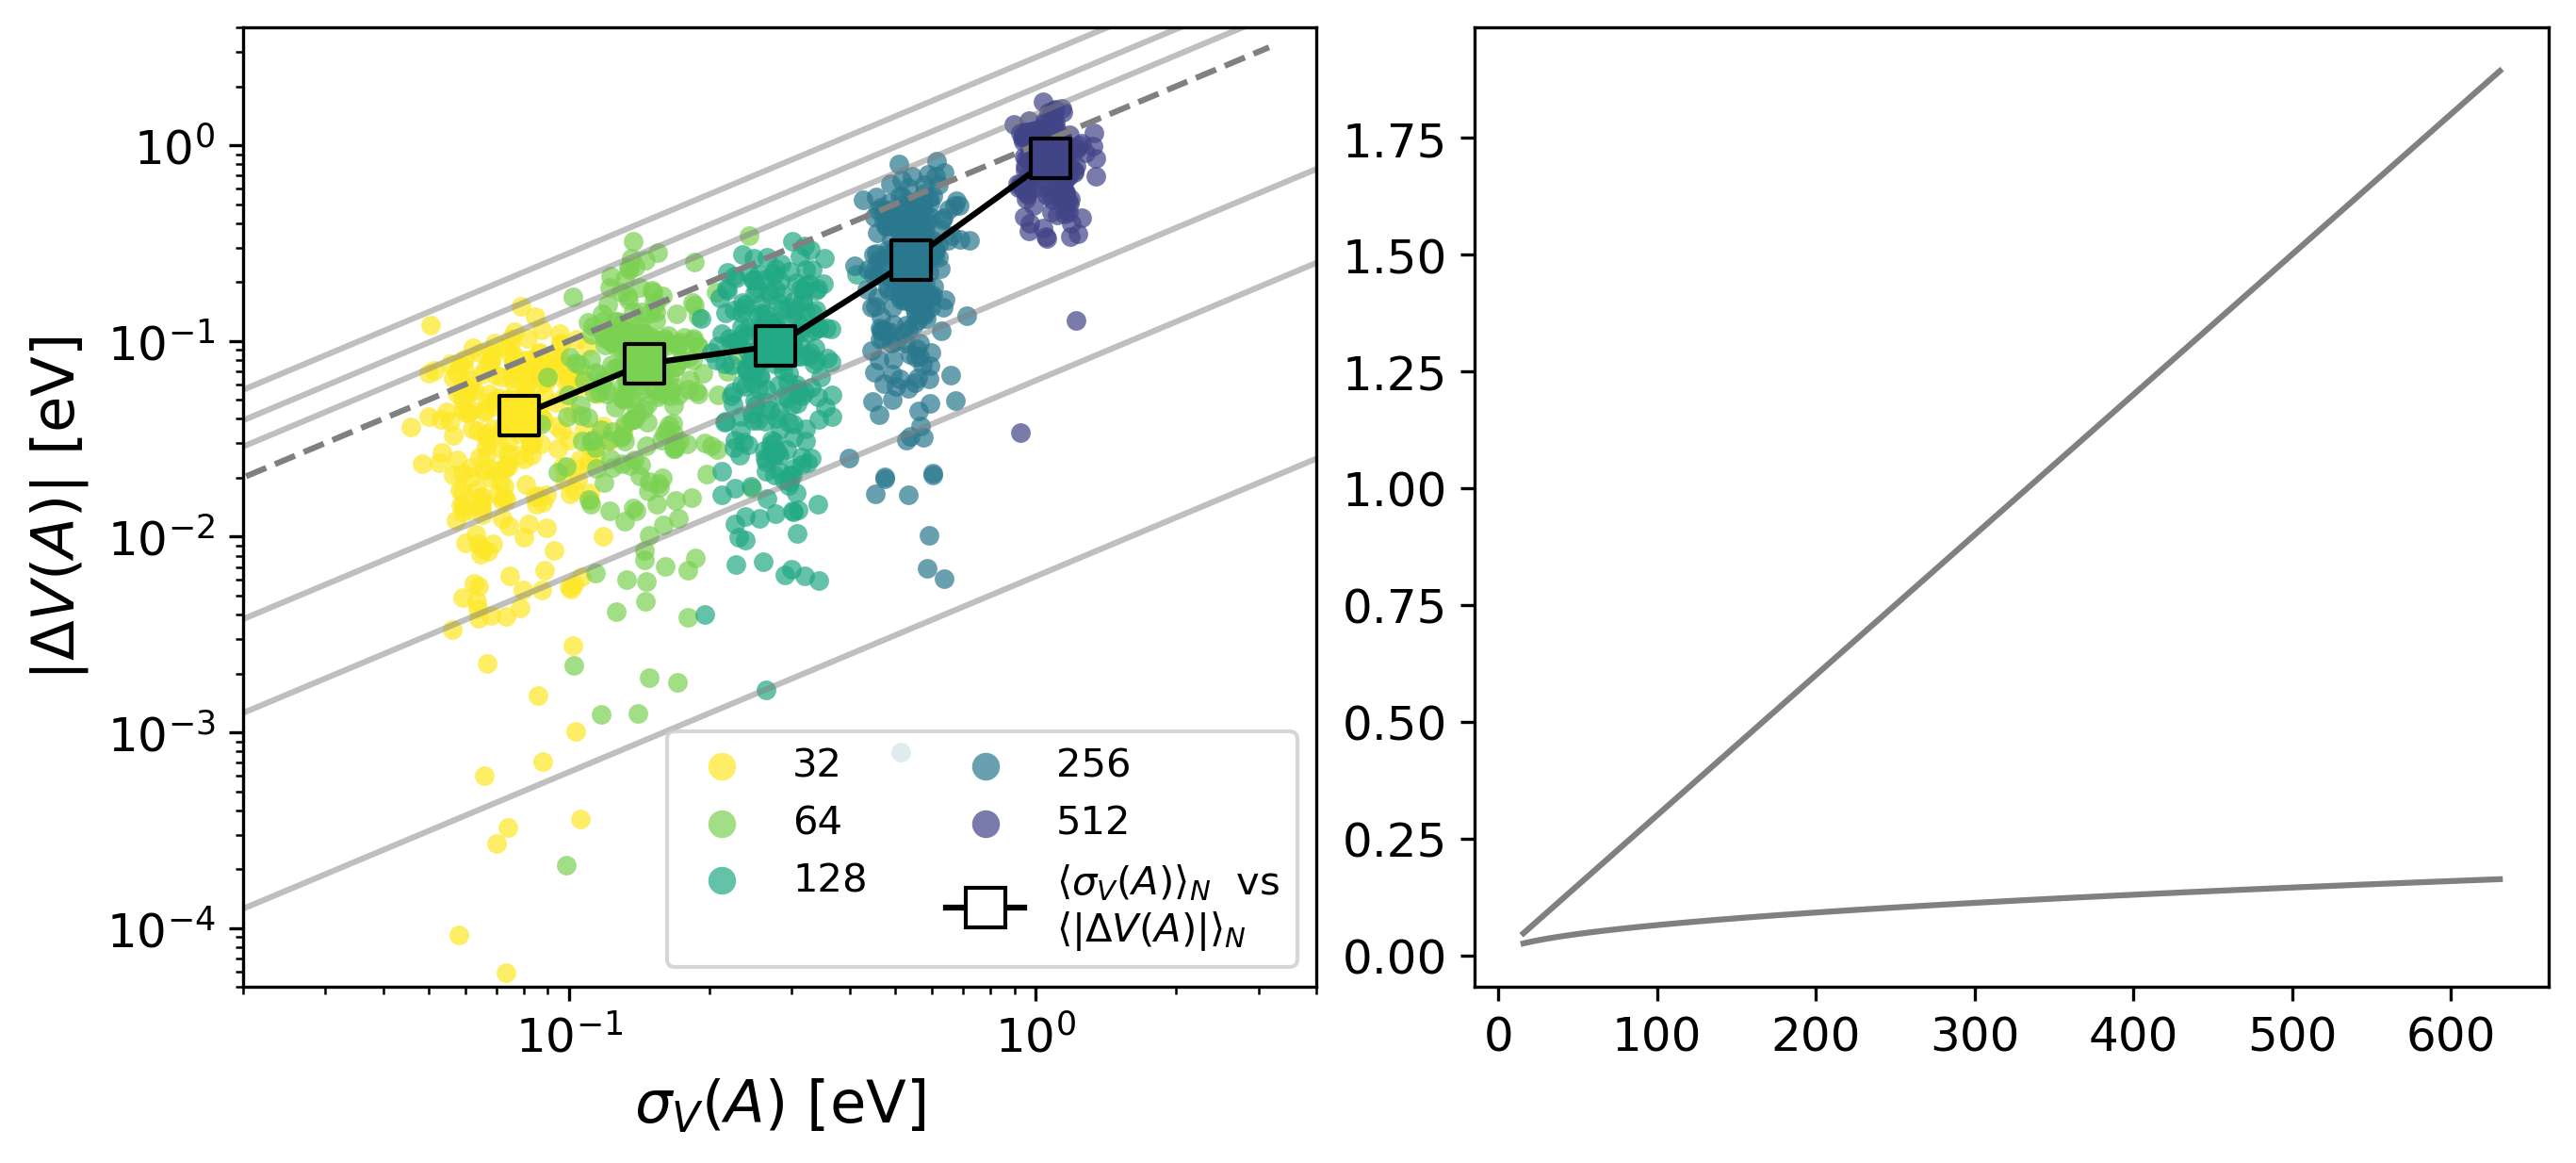

<Figure size 640x460 with 0 Axes>

In [8]:
fig, axs = plt.subplots(1, 2, figsize=(9, 4),dpi=300,constrained_layout=True,)
# H2O
x = np.linspace(2e-5, 5e0, 5)

cmap = plt.get_cmap('viridis')
plt.rc('axes', labelsize=13.5)
plt.rcParams.update({'font.size': 11.0})
matplotlib.rc('xtick', labelsize=12.0) 
matplotlib.rc('ytick', labelsize=12.0) 
plt.rc('axes', labelsize=15.)

colors = cmap(np.linspace(1., 0.2, 5))

#Ytrue[0:250], Ytrue[250:500] = Ytrue[250:500].copy(), Ytrue[0:250].copy()
#Ypred[0:250], Ypred[250:500] = Ypred[250:500].copy(), Ypred[0:250].copy()
#Ypred_std[0:250], Ypred_std[250:500] = Ypred_std[250:500].copy(), Ypred_std[0:250].copy()
ALPHA_SCATTER = 0.7

z_512 = np.abs(Ytrue_512-Ypre_512)
z_mean_512 = np.mean(z_512)



z = np.abs(Ytrue-Ypred).reshape(4,250)
err_pred = Ypred_std.reshape(4,250)

z_mean = np.mean(z,axis=1).T
z_std = np.std(z,axis=1).T

mean_uq = np.mean(Ypred_std.reshape(4,250),axis=1)
std_uq = np.std(Ypred_std.reshape(4,250),axis=1)


sizes_dft = np.array([32,64,128,256])
plt.figure(figsize=(6.4,4.6))

MARKERSIZE = 25.

id = -4
axs[0].scatter(err_pred[id],z[id],color=colors[0], s=MARKERSIZE, rasterized=True, alpha=ALPHA_SCATTER, linewidth=0)
axs[0].scatter([],[],label="{}".format(sizes_dft[id]), alpha=ALPHA_SCATTER,color=colors[0],linewidth=0,s=50.)

id = -3
axs[0].scatter(err_pred[id],z[id],color=colors[1], s=MARKERSIZE, rasterized=True, alpha=ALPHA_SCATTER, linewidth=0)
axs[0].scatter([],[],label="{}".format(sizes_dft[id]), alpha=ALPHA_SCATTER,color=colors[1],linewidth=0,s=50.)

id = -2
axs[0].scatter(err_pred[id],z[id],color=colors[2],s=MARKERSIZE,  rasterized=True, alpha=ALPHA_SCATTER, linewidth=0)
axs[0].scatter([],[],label="{}".format(sizes_dft[id]), alpha=ALPHA_SCATTER,color=colors[2],linewidth=0,s=50.)

id = -1
axs[0].scatter(err_pred[id],z[id],color=colors[3], s=MARKERSIZE, rasterized=True, alpha=ALPHA_SCATTER, linewidth=0)
axs[0].scatter([],[],label="{}".format(sizes_dft[id]), alpha=ALPHA_SCATTER,color=colors[3],linewidth=0,s=50.)

axs[0].scatter(Ypred_std_512,z_512 ,color=colors[4], s=MARKERSIZE, rasterized=True, alpha=ALPHA_SCATTER, linewidth=0)
axs[0].scatter([],[],label="{}".format("512"), alpha=ALPHA_SCATTER,color=colors[4],linewidth=0,s=50.)

axs[0].plot(x, quantiles_upper_05, color='gray', alpha=0.5)
axs[0].plot(x, quantiles_lower_05, color='gray', alpha=0.5)
axs[0].plot(x, quantiles_upper_01, color='gray', alpha=0.5)
axs[0].plot(x, quantiles_lower_01, color='gray', alpha=0.5)
axs[0].plot(x, quantiles_upper_005, color='gray', alpha=0.5)
axs[0].plot(x, quantiles_lower_005, color='gray', alpha=0.5)

axs[0].plot(np.logspace(-2,0.5),np.logspace(-2,0.5),linestyle="--", color="grey")


#make big
for i in range(5):
    axs[0].scatter(np.concatenate([mean_uq.flatten(),np.mean(Ypred_std_512).flatten()])[i],
                   np.concatenate([z_mean.flatten(),z_mean_512.flatten()])[i],marker='s',
                     s=100, edgecolors='black',c=colors[i], zorder=2)
    


axs[0].plot([],[] , 
            's', linestyle="-",  markersize=10, markeredgecolor='black',markerfacecolor="white", color="black", label=r"$\langle\sigma_{V}(A)\rangle_{N}$  vs " + "\n" + r"$\langle|\Delta V(A)|\rangle_{N}$")

axs[0].plot(np.concatenate([mean_uq.flatten(),np.mean(Ypred_std_512).flatten()]),
            np.concatenate([z_mean.flatten(),z_mean_512.flatten()]) ,
            linestyle="-",color="black",zorder=1)


#plt.plot(sizes[:7],z_std, marker="o")
#plt.plot(np.logspace(-2,0),np.sqrt(np.logspace(-2,0))*0.1)
axs[0].set_xscale("log")
axs[0].set_yscale("log")
axs[0].set_xlim(2e-02,4e0)
axs[0].set_ylim(5e-05,4e0)
legend = axs[0].legend(fontsize=10., ncols=2) #markerscale=2.)
#axs[0].set_title(r"Shallow ensemble NLL, no calibration")
axs[0].set_xlabel(r"$\sigma_{V}(A)$ [eV]")
axs[0].set_ylabel(r"$|\Delta V(A)|$ [eV]")


# Adjusting the marker size in the legend
desired_size = 25  # Specify the desired size here
#for handle in legend.legendHandles:
#    handle.set_markersize(desired_size) 
#legend.legendHandles[0]._legmarker.set_markersize(15)

axs[1].plot(np.logspace(1.2,2.8,), 0.003*np.logspace(1.2,2.8),linestyle="-",color="gray", label=r"N")
axs[1].plot(np.logspace(1.2,2.8,), 0.0065*np.sqrt(np.logspace(1.2,2.8)),linestyle="-", color="gray", label=r"$\sqrt{N}$")
add_inline_labels(axs[1], with_overall_progress=True, fontsize="small")

handle_tot, = axs[1].plot(sizes,err_tot_pred, marker="o", linestyle="--", color="black")#, label=r"total$_{(pred)}$")
handle_tot_2, = axs[1].plot(sizes,err_tot_empirical, marker="o", linestyle="-",color="black",label="total")# label=r"total$_{(empir)}$")

handle4, = axs[1].plot(sizes, bias_tot_pred, linestyle="--", color="tab:blue",marker="o")#,label=r"bias$_{(pred)}$")
#handle10, = axs[1].plot(sizes, predicted_bias_2, color="red")
handle5, = axs[1].plot(sizes, bias_tot_empirical, marker="o", color="tab:blue",label="bias") #, label=r"bias$_{(empir)}$" )
#axs[1].plot(sizes, bias_tot_pred, marker="o", color="tab:orange", linestyle="--",label=r"std$[\overline{V}_{n} - \overline{V}_{true}]$")

handle6, = axs[1].plot(sizes, err_thermal_empirical, marker="o", linestyle="-", color="lightsalmon", label="residual")# label=r"resid$_{(empir)}$")
handle7, = axs[1].plot(sizes, err_thermal_pred, marker="o", linestyle="--", color="lightsalmon")#, label=r"resid$_{(pred)}$")


handle8, = axs[1].plot([],[], linestyle="-", color="dimgray", label="empirical" )
handle9, = axs[1].plot([],[], linestyle="--", color="dimgray", label="predicted" )

#plt.plot(sizes, np.array(bias_tot_pred)+np.array(err_thermal_pred), marker="o", color="tab:red", linestyle="--", label=r"")



#axs[1].plot(np.logspace(1.5,2.8,), 0.008*np.sqrt(np.logspace(1.5,2.8)),linestyle="--", color="gray")#, label=r"$\sqrt{N}$")

axs[1].loglog()
axs[1].set_xlabel(r"N$_{H_{2}O}$")
axs[1].set_ylabel("$|\Delta V(A)|$ [eV]")
axs[1].legend(loc="lower right", 
              handles=[handle_tot,handle_tot_2,
                       handle4,handle5,handle6,handle7,handle8,handle9])#bbox_to_anchor=(1.1,1))

axs[0].text(0.1, 0.9, 'a)', horizontalalignment='center', verticalalignment='center', transform=axs[0].transAxes, fontsize=15)
axs[1].text(0.1, 0.9, 'b)', horizontalalignment='center', verticalalignment='center', transform=axs[1].transAxes, fontsize=15)

#set explicit x ticks
axs[1].set_xticks(sizes)
axs[1].set_xticklabels(sizes)
axs[1].set_xlim(30,540)

plt.show()

fig.savefig("size_extensive_error_analysis_transposed.pdf",bbox_inches='tight',dpi=300)


